# Using U-net style architecture for semantic segmentation
I will train a u-net-style architecture on the labeled city dataset from 

### Params

In [0]:
batch_size = 4
target_size = (512,256)
n_epochs = 25
learning_rate = 0.000_001
run_once, fix_masks = False, False # to load/unzip/fix data, fix masks

## Environment

In [2]:
# get colab status
try:
  import google.colab
  IN_COLAB = True
  %tensorflow_version 2.x
except:
  IN_COLAB = False

TensorFlow 2.x selected.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Dropout, 
MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate, Input)
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.data_utils import Sequence # to fix 'imagedatagenerator has no shape' error
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import os, zipfile, glob, shutil
from math import ceil 
from PIL import Image
from skimage import io, transform
import imageio.core.util  # so can be patched
import warnings

In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir(r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/')
else:
    os.chdir(os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/'))
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data


# Data Load
### Cityscape Dataset
This is a publically availible dataset from https://www.cityscapes-dataset.com/, though not downloadable without requesting a login which is granted based on email domain.
Citation:  
>Cvpr2016M. Cordts, M. Omran, S. Ramos, T. Rehfeld, M. Enzweiler, R. Benenson, U. Franke, S. Roth, and B. Schiele, “The Cityscapes Dataset for Semantic Urban Scene Understanding,” in Proc. of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016. [Bibtex]
[main paper](https://www.cityscapes-dataset.com/wordpress/wp-content/papercite-data/pdf/cordts2016cityscapes.pdf) · [supplemental ](https://www.cityscapes-dataset.com/wordpress/wp-content/papercite-data/pdf/cordts2016cityscapes-supplemental.pdf)· [arxiv](http://arxiv.org/abs/1604.01685) · [CVF](http://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Cordts_The_Cityscapes_Dataset_CVPR_2016_paper.html)


In [0]:
if run_once: # run once
  os.chdir(r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/')
  with zipfile.ZipFile(os.path.join(os.getcwd(), 'gtFine_trainvaltest.zip'), 'r') as zip_ref:
    zip_ref.extractall("./cityscape/")

In [0]:
#Color for sidewalk in mask from cityscape website:
sidewalk_color = np.array([244, 35, 232])

### downsample images and fix directory structure

In [0]:
def color_checker(color):
    '''looks for color used to code sidewalks'''
    return 1 if np.array_equal(color, sidewalk_color) else 0

In [0]:
def resize(path, destination):
    '''
    downsample images by 4x, 
    remove transparency layer, 
    save to flattened dir stuc
    Args:
        path = current directory
        destination = destination for images
    '''
    dirs1 = np.array([os.path.join(path, x) for x in os.listdir(path)])
    dirs = dirs1[[os.path.isdir(x) for x in dirs1]]
    for direc in dirs:   # direc should be mask vs image folders
        if not os.path.isdir(direc):
            continue
        subdirs = [os.path.join(direc, x) for x in os.listdir(direc)]
        for subdir in subdirs:   # subdir should be train, val, test
            subdirs2 = [os.path.join(subdir, x) for x in os.listdir(subdir)]
            for subdir2 in subdirs2:   # subdir2 is city folders
                items = os.listdir(subdir2)
                for item in items:
                    if not os.path.isfile(os.path.join(subdir2,item)):
                        continue
                    #skip json and noncolor masks
                    if item.rfind('gtFine_color.png') == -1 \
                    and item.rfind('leftImg8bit.png') == -1:
                        continue
                    #if item.rfind('leftImg8bit.png') != -1:  # remove if doing images
                    #    continue
                    destin2 = os.path.join(destination, subdir[len(common_path)+1:])
                    f, _ = os.path.splitext(item)
                    if not os.path.exists(destin2):
                        os.makedirs(destin2)
                    destin3 = os.path.join(destin2, f+'_resized.png')
                    ###########WARNING
                    #ADDED transfomation for masks. IF running 
                    #from scratch, add logic to treat masks vs images separately
                    ###############
                    #filename = os.path.join(subdir2, item)
                    #im = io.imread(filename)
                    #im = im[:,:,0:3]  # remove alpha channel
                    #reduced_im = np.apply_along_axis(color_checker, 2, im).astype(np.intc)
                    #reduced_im = transform.resize(reduced_im, 
                    #                            (256,512), 
                    #                            preserve_range=True, 
                    #                            anti_aliasing=False).astype(np.bool_).astype(np.intc)
                    #io.imsave(destin3, reduced_im) 



                    im = Image.open(os.path.join(subdir2, item))
                    if im.mode == "RGBA":
                        im = im.convert('RGB')
                    im = im.resize((512,256), Image.BICUBIC)
                    im.save(destin3, format='PNG')
                    im.close()

In [33]:
#switch to cloud dir
if IN_COLAB:
    data_mount = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/'  
    destin = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/'
else:
    data_mount = os.path.expanduser(
        r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/public_data/')
    destin = os.path.expanduser(
        r"~\Documents\GitHub\sidewalks_deep-learning\cityscape_reduced")
leftimages_path = os.path.join(data_mount, r'cityscape/leftImg8bit/') # no leading /
mask_path = os.path.join(data_mount, r'cityscape/gtFine/')
common_path = os.path.join(data_mount, r'cityscape')
image_dest_path = os.path.join(destin, r'leftImg8bit')
mask_dest_path = os.path.join(destin, r'sidewalk_only_masks')
os.chdir(common_path)
mask_dest_path

'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/sidewalk_only_masks'

In [0]:
if run_once:
  resize(common_path, destin)

### Adjust masks to only separate sidewalk vs non-sidewalk

In [14]:
! pwd

/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape


In [0]:
#Requires both patching library and regular filterwarnings to avoid 
#warnings about low resolution!
def silence_imageio_warning(*args, **kwargs):
    pass
imageio.core.util._precision_warn = silence_imageio_warning

In [0]:
def mask_reduce(old_file, new_file):
    '''reduces images from rgb to b/w mask'''
    im = io.imread(old_file)
    im = im[:,:,0:3]  # remove alpha channel
    reduced_im = np.apply_along_axis(color_checker, 2, im).astype(np.intc)
    reduced_im = transform.resize(reduced_im, 
                                  (256,512), 
                                  preserve_range=True, 
                                  anti_aliasing=False).astype(np.bool_).astype(np.intc)
    #all black images throw error
    try:
        io.imsave(new_file, reduced_im) 
    except ValueError:
        io.imsave(new_file, reduced_im.astype('float64'))

create dataframe of mask files to operate on and intended output filename

In [0]:
common_path_new = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced'

In [0]:
if fix_masks:
    file_list = ! find . -name "*_gtFine_color.png"
    mask_fixes_df = pd.DataFrame([path.split("/") for path in file_list])
    mask_fixes_df.columns = ['dot', 'group', 'subset', 'city', 'filename']
    mask_fixes_df['dest_path'] = common_path_new + r'/sidewalk_only_masks/' + \
    mask_fixes_df.subset + '/' + mask_fixes_df.filename
    mask_fixes_df['old_path'] = file_list
    mask_fixes_df['old_path'] = mask_fixes_df['old_path'].apply(lambda x: common_path + x[1:])
    mask_fixes_df.head()

In [0]:
if fix_masks:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        warnings.filterwarnings('ignore')
        #apply fix to all mask files
        mask_fixes_df.apply(lambda x: mask_reduce(x.old_path, x.dest_path), axis=1)

In [0]:
os.chdir(destin)

### Data Generator

In [0]:
def get_image_locs(subset):    
    '''grab name of every image 
    and store in dataframe with subset eg. train, test'''
    df = pd.DataFrame(columns=['img_name', 'subset'])
    if subset == 'img':
        os.chdir(leftimages_path) # needed despite lack of reference to curpath
        img_paths = os.listdir(leftimages_path)
        search_for = '*/*'
    elif subset == 'mask': 
        os.chdir(mask_path)
        img_paths = os.listdir(mask_path)   
        search_for = '*/*_gtFine_color.png'
    else:
        raise NameError("subset should be 'img' or 'mask'")
    for subsetdir in img_paths:
        img_files = [x[len(subsetdir)+1:] for x in glob.glob(os.path.join(subsetdir, search_for))]
        img_files_s = pd.Series(img_files)
        new_df = None
        new_df = pd.DataFrame(columns=['img_name', 'subset'])
        new_df['img_name'] = img_files_s
        new_df['subset'].fillna(subsetdir, inplace=True)
        df = df.append(new_df)
    return df

In [0]:
def clean_name(name):
  '''removes _gtFine_color.png or _leftImg8bit.png'''
  which = name.rfind('_leftImg8bit.png')
  if which == -1:
    which = '_gtFine_color.png'
  else:
    which =  '_leftImg8bit.png'
  loc=name.rfind(which)
  return name[:loc]

In [0]:
data_df = get_image_locs('img')
mask_df = get_image_locs('mask')

In [0]:
data_df['common_name'] = data_df.img_name.apply(clean_name)
mask_df['common_name'] = mask_df.img_name.apply(clean_name)

In [0]:
data_full_df = None
data_full_df = pd.merge(left=data_df, right=mask_df, 
                        how='inner', on='common_name',
                        sort=False, 
                        suffixes=('_data', '_mask'))\
               [['img_name_data', 'subset_data', 'img_name_mask']]
data_full_df.columns = ['img_name', 'subset_data', 'mask_name']

In [0]:
class ImgLoadGenerator(Sequence):
    """
    parent Sequence object generates data batches
    """
    def __init__(self, data, batch_size, data_path, subset, widthxheight): 
        self.data = data[data.subset_data == subset]
        self.data_path = data_path
        self.batch_size = batch_size
        self.image_list = data.img_name.to_list()
        self.mask_list = data.mask_name.to_list()
        self.subset = subset
        self.w_h = widthxheight
       
    def __len__(self):
      """last batch usually smaller"""
      return int(np.ceil(len(self.image_list) / float(self.batch_size)))
    def decode_img(self, file_path):
        img = tf.io.read_file(file_path)
        # convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # to [0,1] rng
        return tf.image.resize(img, self.w_h)
    def process_path(self, file_path):
        # load the raw data from the file as a string

        return img, label
    def get_batch(self, idx, path_list, img_or_mask):
        # Fetch a batch of images from a list of paths
        if img_or_mask == 'img':
            path_l = os.path.join(self.data_path, "leftImg8bit", self.subset)
            col_slice = 0
        else:
            path_l = os.path.join(self.data_path, "gtFine", self.subset)
            col_slice = 2
        slice_start, slice_end = idx * self.batch_size, (1 + idx) * self.batch_size
        im_set = self.data.iloc[slice_start:slice_end,col_slice].values
        return np.array([self.decode_img(os.path.join(path_l, im)) for im in im_set])
    def __getitem__(self, idx):
        batch_x = self.get_batch(idx, self.image_list, 'img')
        batch_y = self.get_batch(idx, self.mask_list, 'mask')
        return batch_x, batch_y

In [0]:
gen_params = {'data':data_full_df,
              'batch_size':8, 
              'data_path':common_path, 
              'widthxheight':target_size}
train_generator = ImgLoadGenerator(subset='train', 
                                   **gen_params)
vdate_generator = ImgLoadGenerator(subset='val',
                                   **gen_params)

# ImageDataGenerator class

In [56]:
#create some subfolders for flow_for_directory
subset = ['train', 'test', 'val']
pathset = [mask_dest_path, image_dest_path]
for sub in subset:
    for path in pathset:
        new_path = os.path.join(path, sub, 'folder0')
        if not os.path.exists(new_path):
            os.mkdir(new_path)
        file_listing = os.listdir(os.path.join(path,sub))
        file_listing = [file for file in file_listing if file!=new_path]        
        for file in file_listing:
            src=os.path.join(path,sub,file)
            dst=os.path.join(new_path,file)
            try:
                shutil.move(src,dst)
            except OSError:
                pass

/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/sidewalk_only_masks/train/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/leftImg8bit/train/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/sidewalk_only_masks/test/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/leftImg8bit/test/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/sidewalk_only_masks/val/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/leftImg8bit/val/folder0


In [31]:
os.path.join(mask_dest_path, 'train')

'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/sidewalk_only_masks/train'

# combined generators

In [113]:
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)
seed=42
ffd_params = dict(class_mode=None,
                  target_size=target_size,
                  seed=seed,
                  batch_size=batch_size,
                  )
image_generator = image_datagen.flow_from_directory(
    os.path.join(image_dest_path, r'train'),
    **ffd_params)

mask_generator = mask_datagen.flow_from_directory(
    os.path.join(mask_dest_path, r'train'),
    color_mode='grayscale',
    **ffd_params)

# combine generators into one which yields image and masks
def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

train_generator_ffd = combine_generator(image_generator, mask_generator)

Found 2975 images belonging to 1 classes.
Found 352 images belonging to 1 classes.


# Modeling
I will build a basic U-net model, train it on the cityscape public dataset, and use that model & weights on the Denver dataset I have built. 

Model structure reference [here](http://cs230.stanford.edu/files_winter_2018/projects/6937642.pdf)

Next, I will use the frozen weights from the first have of the model, 

In [0]:
img_shape = (*target_size, 3)

In [0]:
#use function for the blocks of the network
def encoder_builder(input_, filters,
                         activ='relu', kernel=(3,3), 
                         drop=.5, pad='same', kern_init='he_uniform'):
  kwargs = {'filters': filters, 'activation': activ, 'kernel_size': kernel, 
       'padding': pad, 'kernel_initializer': kern_init}
  x = Conv2D(**kwargs)(input_)
  x = BatchNormalization()(x)
  x = Dropout(drop)(x)
  x = Conv2D(**kwargs)(x)
  encoder = Dropout(drop)(x)
  pooled = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)
  return encoder, pooled

def decoder_builder(input_, skip, filters, 
                    activ='relu', kernel=(2,2),
                    drop=.5, pad='same', kern_init='he_uniform',
                    ):
  kwargs = {'filters': filters, 'activation': activ, 'kernel_size': kernel, 
       'padding': pad, 'kernel_initializer': kern_init} 
  x = Conv2DTranspose(**kwargs, strides=(2,2))(input_)
  x = concatenate([x, skip], axis=-1)  # note axis is *-*1
  x = BatchNormalization()(x)
  x = Dropout(drop)(x)
  x = Conv2D(**kwargs)(x)
  x = BatchNormalization()(x)
  x = Dropout(drop)(x)
  x = Conv2D(**kwargs)(x)
  return x

In [0]:
input_layer = Input(shape=img_shape)
encoder1, pooled1 = encoder_builder(input_layer, filters=16)  # return (128x128x32)
encoder2, pooled2 = encoder_builder(pooled1, filters=32)  # return (64x64x364)
encoder3, pooled3 = encoder_builder(pooled2, filters=64)  # return (32x32x128)
encoder4, pooled4 = encoder_builder(pooled3, filters=128)  # return (16x16x256)
#encoder_builder(pooled4, filters=512)  # return (8x8x512)
middle, middle_pool = encoder_builder(pooled4, filters=128)  # return (4x4x1024)
#decoder512 = decoder_builder(middle, skip=encoder5, filters=512)
decoder256 = decoder_builder(middle, skip=encoder4, filters=128)
decoder128 = decoder_builder(decoder256, skip=encoder3, filters=64)
decoder64 = decoder_builder(decoder128, skip=encoder2, filters=32)
decoder32 = decoder_builder(decoder64, skip=encoder1, filters=16)
out_layer = Conv2D(filters=1, kernel_size=(1, 1), 
                   activation='sigmoid')(decoder32)

####copied code
#final_conv_out = Conv2D(n_classes, 1, 1)(conv9)

#x = Reshape((2, rows*cols))(final_conv_out)
#x = Permute((2,1))(x)

# seg is a pixelwise probability vector sized (batch_size, rows*cols, n_classes)
#seg = Activation("softmax")(x)                   

In [0]:
unet = models.Model(inputs=[input_layer], outputs=[out_layer])

In [119]:
unet.compile(optimizer='adam', 
             loss = tf.keras.losses.binary_crossentropy, 
             metrics = ['accuracy'])
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_111 (Conv2D)             (None, 512, 256, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 512, 256, 16) 64          conv2d_111[0][0]                 
__________________________________________________________________________________________________
dropout_106 (Dropout)           (None, 512, 256, 16) 0           batch_normalization_77[0][0]     
____________________________________________________________________________________________

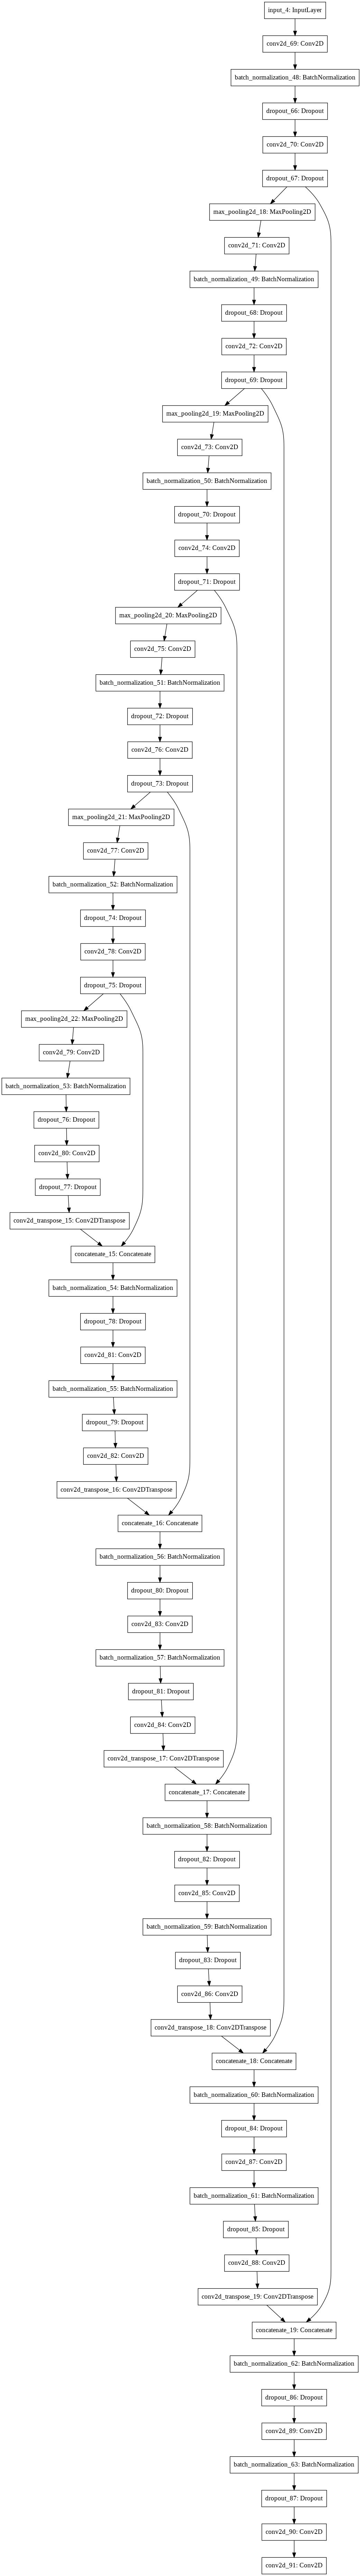

In [91]:
plot_model(unet, to_file='model.png')

### Training

In [0]:
input_shape = img_shape
total_train_samples = data_full_df[data_full_df.subset_data == 'train'].shape[0]
total_vdate_samples = data_full_df[data_full_df.subset_data == 'val'].shape[0]

In [0]:
save_model_path = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/weights.hdf5'
cp = ModelCheckpoint(filepath=save_model_path, 
                                        monitor='accuracy', 
                                        save_best_only=True, 
                                        verbose=1)

In [0]:
unet_history = unet.fit_generator(
    train_generator_ffd, 
    steps_per_epoch=int(total_train_samples/batch_size),
    epochs=n_epochs,
    verbose=1,
    #validation_data=vdate_generator,
    #validation_steps=int(total_vdate_samples/batch_size),
    callbacks = [cp])

Epoch 1/25
254/743 [=========>....................] - ETA: 1:35 - loss: 0.2630 - accuracy: 0.9188